In [643]:
#import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [644]:
#!pip install lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [645]:
import warnings
warnings.filterwarnings('ignore')

In [646]:
df_players = pd.read_csv('df_players.csv')

In [647]:
#make model for batting
df_players_batting = df_players.copy()

In [648]:
df_players_batting.columns

Index(['Unnamed: 0', 'player_mlb_id', 'playerID_LAHMAN', 'birthYear',
       'birthMonth', 'birthDay', 'birthCountry', 'weight', 'height', 'bats',
       ...
       'batter_avg_exp_ba', 'pitcher_avg_exp_ba', 'batter', 'wOBA_batter',
       'pitcher', 'wOBA_pitcher', 'primary_position', 'age', 'years_before_26',
       'years_after_28'],
      dtype='object', length=190)

In [649]:
current_batter_features = [
    'player_mlb_id',
    'year',
    'age',
    'years_before_26',
    'years_after_28',
    'bats',
    'primary_position',
    'avg',
    'obp',
    'ops',
    'slg',
    'iso',
    'k_rate_batter',
    'bb_rate_batter',
    'batter_avg_exp_ba',
    'babip_batter',
    'fly_balls_ratio_batter',
    'ground_balls_ratio_batter',
    'line_drives_ratio_batter',
    'popups_ratio_batter',
    'hr_fb_pct_batter',
    'avg_lineup_position',
    'wOBA_batter',
    'total_pa'
    #regress stats based on 50 league average plate appearances
]

Get averages per year

In [651]:
df_players_batting = df_players_batting[current_batter_features]

In [652]:
df_players_batting_means = df_players_batting[df_players_batting['total_pa'] > 1]

#select numeric columns and columns needed for groupby
numeric_cols = df_players_batting_means.select_dtypes(include=np.number).columns.tolist()
numeric_cols += ['primary_position']
df_players_batting_means = df_players_batting_means[numeric_cols]

#get means
weighted_means_position = df_players_batting_means.groupby(['year', 'primary_position']).apply(
    lambda group: group.apply(
        lambda col: np.average(col.dropna(), weights=group.loc[col.dropna().index, 'total_pa']) 
        if col.name != 'total_pa' and group.loc[col.dropna().index, 'total_pa'].sum() > 0
        else col.mean(),  # Use col.mean() for total_pa column
        axis=0
    )
)
weighted_means_position = weighted_means_position.reset_index()

In [653]:
#for unknown positions, use the leaguewide average instead
df_players_batting_means_league = df_players_batting[df_players_batting['total_pa'] > 1]

numeric_cols = df_players_batting_means_league.select_dtypes(include=np.number).columns.tolist()

weighted_means_league = df_players_batting_means_league.groupby('year')[numeric_cols].apply(
    lambda group: group.apply(
        lambda col: np.average(col.dropna(), weights=group.loc[col.dropna().index, 'total_pa']) 
        if col.name not in ['total_pa'] and group.loc[col.dropna().index, 'total_pa'].sum() > 0
        else col.mean(),  # Use col.mean() for total_pa column
        axis=0
    )
)

weighted_means_league['primary_position'] = 'Unknown'

In [654]:
#for unknown positions, use league averages
unknown_rows = weighted_means_position[weighted_means_position['primary_position'] == 'Unknown']

for year in unknown_rows['year'].unique():
    replacement_row = weighted_means_league[weighted_means_league['year'] == year].iloc[0]
    weighted_means_position.loc[
        (weighted_means_position['primary_position'] == 'Unknown') & 
        (weighted_means_position['year'] == year), 
        numeric_cols] = replacement_row[numeric_cols].values

Back to model

In [669]:
df_players_batting.isna().sum()

player_mlb_id                   0
year                            0
age                             0
years_before_26                 0
years_after_28                  0
bats                            0
primary_position                0
avg                          5280
obp                          5273
ops                          5280
slg                          5280
iso                          5280
k_rate_batter                5268
bb_rate_batter               5268
batter_avg_exp_ba            5373
babip_batter                 5372
fly_balls_ratio_batter       5576
ground_balls_ratio_batter    5411
line_drives_ratio_batter     5554
popups_ratio_batter          5722
hr_fb_pct_batter             5576
avg_lineup_position          5268
wOBA_batter                  5272
total_pa                        0
dtype: int64

In [671]:
#fill with 0 for these nulls
df_players_batting = df_players_batting.fillna(0)

In [691]:
#make new columns that compare player's stats to league average for position group
df_players_batting

,player_mlb_id,year,age,years_before_26,years_after_28,bats,primary_position,avg,obp,ops,...,batter_avg_exp_ba,babip_batter,fly_balls_ratio_batter,ground_balls_ratio_batter,line_drives_ratio_batter,popups_ratio_batter,hr_fb_pct_batter,avg_lineup_position,wOBA_batter,total_pa
0,0629cd765e77d52b8a43cb56621c82d949e50323,2021,36,0,8,L,p,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,2021,26,0,0,R,p,0.33,0.33,0.67,...,0.20,0.50,0.00,0.67,0.00,0.00,0.00,10.50,0.30,3
2,f79cf1f3d100e5f34d86ce2cd4c8c35ca3daee77,2021,21,5,0,L,ss,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
3,3d65b1ac983ce90ff1f21f56b627883affc7dad1,2021,24,2,0,R,p,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
4,80f3a94c7bf1ed6397017744dbb75ff931902e2d,2021,34,0,6,R,1b,0.25,0.34,0.80,...,0.34,0.29,0.19,0.35,0.16,0.04,0.27,3.37,0.37,657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7471,fb700ef074fe19c9c4328e120dd91c7b03c044cc,2023,27,0,0,R,p,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
7472,0cb4ea486038c8edcb71036139fcef171a27fe97,2023,23,3,0,R,p,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
7473,128f3d8f2092540735e1a741529518b8058d4758,2023,24,2,0,R,p,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
7474,11414d3c42573a52b9032d1287494a78a912c4af,2023,30,0,2,R,p,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [741]:
df_batting_w_relative = df_players_batting.merge(weighted_means_position, on=['year','primary_position'], how='left', suffixes=('','_rel'))
df_batting_w_relative[['avg','avg_rel']].head()

,avg,avg_rel
0,0.00,0.13
1,0.33,0.13
2,0.00,0.26
3,0.00,0.13
4,0.25,0.25


In [743]:
# Iterate over all columns
for col in df_batting_w_relative.columns:
    # Check if column ends with '_rel'
    if col.endswith('_rel'):
        # Create the name of the corresponding column without '_rel'
        original_col = col[:-4]  # Remove the '_rel' suffix
        if original_col in df_batting_w_relative.columns:
            # Subtract the original column from the '_rel' column and assign it back
            df_batting_w_relative[col] = (df_batting_w_relative[original_col] / df_batting_w_relative[col])*100

In [747]:
df_batting_w_relative[['avg','avg_rel']].head(20)

,avg,avg_rel
0,0.00,0.00
1,0.33,262.25
2,0.00,0.00
3,0.00,0.00
4,0.25,100.94
5,0.00,0.00
6,0.27,109.43
7,0.00,0.00
8,0.26,102.24
9,0.00,0.00


In [749]:
df_2021 = df_batting_w_relative[df_batting_w_relative['year'] == 2021]
df_2022 = df_batting_w_relative[df_batting_w_relative['year'] == 2022]
df_2023 = df_batting_w_relative[df_batting_w_relative['year'] == 2023][['player_mlb_id','total_pa','age','years_before_26','years_after_28','bats','primary_position']]
df_all = df_2021.merge(df_2022, on='player_mlb_id', how='outer', suffixes=("_2ya","_1ya")).drop(columns=['year_2ya','year_1ya'])
df_all = df_all.merge(df_2023, on='player_mlb_id',how='outer').drop(columns='player_mlb_id')

In [751]:
df_all['total_pa_avg'] = df_all['total_pa_1ya']*.6 + df_all['total_pa_2ya']*.4

In [753]:
#avoid infinite values
df_all.replace(np.inf, 1, inplace=True)

In [755]:
#check for nulls
df_all.isna().sum()

age_2ya                 0
years_before_26_2ya     0
years_after_28_2ya      0
bats_2ya                0
primary_position_2ya    0
                       ..
years_before_26         0
years_after_28          0
bats                    0
primary_position        0
total_pa_avg            0
Length: 91, dtype: int64

In [265]:
# #fill in empty columns for batting hand
# df_50['bats'] = df_50['bats'].fillna(df_50['bats_1ya']).fillna(df_50['bats_2ya'])

# #fill in empty ages/years after debut for players
# df_50['age'] = df_50['age'].fillna(df_50['age_1ya'] + 1).fillna(df_50['age_2ya'] + 2)
# df_50['years_before_26'] = df_50['years_before_26'].fillna(df_50['years_before_26_1ya'] + 1).fillna(df_50['years_before_26_2ya'] + 2)
# df_50['years_after_28'] = df_50['years_after_28'].fillna(df_50['years_after_28_1ya'] + 1).fillna(df_50['years_after_28_2ya'] + 2)
# df_50 = df_50.drop(columns=['age_1ya','age_2ya','years_before_26_1ya','years_before_26_2ya','years_after_28_1ya','years_after_28_2ya','bats_1ya','bats_2ya','primary_position_2ya','primary_position_1ya'])

# #for players who didn't play, set batting position to other year or the min for the year.
# df_50['avg_lineup_position_1ya'] = df_50['avg_lineup_position_1ya'].fillna(df_50['avg_lineup_position_2ya']).fillna(df_50['avg_lineup_position_1ya'].max())
# df_50['avg_lineup_position_2ya'] = df_50['avg_lineup_position_2ya'].fillna(df_50['avg_lineup_position_1ya'])

In [266]:
# #check for nulls
# df_50.isna().sum()

stolen_bases_2ya                 0
avg_2ya                          0
obp_2ya                          0
ops_2ya                          0
slg_2ya                          0
iso_2ya                          0
k_rate_batter_2ya                0
bb_rate_batter_2ya               0
batter_avg_exp_ba_2ya            0
babip_batter_2ya                 0
fly_balls_ratio_batter_2ya       0
ground_balls_ratio_batter_2ya    0
line_drives_ratio_batter_2ya     0
popups_ratio_batter_2ya          2
hr_fb_pct_batter_2ya             0
avg_lineup_position_2ya          0
wOBA_batter_2ya                  0
total_pa_2ya                     0
stolen_bases_1ya                 0
avg_1ya                          0
obp_1ya                          0
ops_1ya                          0
slg_1ya                          0
iso_1ya                          0
k_rate_batter_1ya                0
bb_rate_batter_1ya               0
batter_avg_exp_ba_1ya            0
babip_batter_1ya                 0
fly_balls_ratio_batt

In [687]:
#select only certain features
select_batting_features = [
    'total_pa_1ya', 'avg_lineup_position_1ya', 'obp_1ya', 'slg_1ya',
    'k_rate_batter_1ya', 'bb_rate_batter_1ya', 'years_before_26', 'years_after_28',
    'bats', 'primary_position','total_pa'
]

In [804]:
#df_batting_simp = df_all[select_batting_features]
df_batting_simp = df_all.copy()

In [806]:
#for now drop these
df_batting_simp = df_batting_simp.drop(columns=['years_before_26_rel_1ya', 'years_after_28_rel_1ya'])

In [832]:
df_batting_simp = df_batting_simp[(df_batting_simp['total_pa_2ya']>0) & (df_batting_simp['total_pa_1ya']>0)]
df_batting_simp = df_batting_simp[df_batting_simp['primary_position'] != 'p']

In [834]:
# for col in df_batting_simp.isna().sum().index:
#     print(f"{col}: {df_batting_simp[col].isna().sum()}")

In [866]:
df_batting_simp = df_batting_simp.drop(columns=['primary_position','primary_position_1ya','primary_position_2ya'])

In [884]:
df_batting_simp.columns

Index(['age_2ya', 'years_before_26_2ya', 'years_after_28_2ya', 'bats_2ya',
       'avg_2ya', 'obp_2ya', 'ops_2ya', 'slg_2ya', 'iso_2ya',
       'k_rate_batter_2ya', 'bb_rate_batter_2ya', 'batter_avg_exp_ba_2ya',
       'babip_batter_2ya', 'fly_balls_ratio_batter_2ya',
       'ground_balls_ratio_batter_2ya', 'line_drives_ratio_batter_2ya',
       'popups_ratio_batter_2ya', 'hr_fb_pct_batter_2ya',
       'avg_lineup_position_2ya', 'wOBA_batter_2ya', 'total_pa_2ya',
       'age_rel_2ya', 'years_before_26_rel_2ya', 'years_after_28_rel_2ya',
       'avg_rel_2ya', 'obp_rel_2ya', 'ops_rel_2ya', 'slg_rel_2ya',
       'iso_rel_2ya', 'k_rate_batter_rel_2ya', 'bb_rate_batter_rel_2ya',
       'batter_avg_exp_ba_rel_2ya', 'babip_batter_rel_2ya',
       'fly_balls_ratio_batter_rel_2ya', 'ground_balls_ratio_batter_rel_2ya',
       'line_drives_ratio_batter_rel_2ya', 'popups_ratio_batter_rel_2ya',
       'hr_fb_pct_batter_rel_2ya', 'avg_lineup_position_rel_2ya',
       'wOBA_batter_rel_2ya', 'total_pa

In [968]:
cols_for_model = ['avg_lineup_position_2ya', 'total_pa_2ya',
       #'avg_rel_2ya', 'avg_rel_1ya', 
       #'obp_rel_2ya', 'obp_rel_1ya',
        'ops_rel_2ya', 'ops_rel_1ya',
        #'slg_rel_2ya', 'slg_rel_1ya',
       #'iso_rel_2ya', 'iso_rel_1ya',
        'k_rate_batter_rel_2ya', 'bb_rate_batter_rel_2ya',
       'batter_avg_exp_ba_rel_2ya', 'babip_batter_rel_2ya',
       'fly_balls_ratio_batter_rel_2ya', 'ground_balls_ratio_batter_rel_2ya',
       'line_drives_ratio_batter_rel_2ya', 'popups_ratio_batter_rel_2ya',
       'hr_fb_pct_batter_rel_2ya', 'wOBA_batter_rel_2ya', 'avg_lineup_position_1ya',
       'total_pa_1ya', 
          'k_rate_batter_rel_1ya',
       'bb_rate_batter_rel_1ya', 'batter_avg_exp_ba_rel_1ya',
       'babip_batter_rel_1ya', 'fly_balls_ratio_batter_rel_1ya',
       'ground_balls_ratio_batter_rel_1ya', 'line_drives_ratio_batter_rel_1ya',
       'popups_ratio_batter_rel_1ya', 'hr_fb_pct_batter_rel_1ya', 'wOBA_batter_rel_1ya',
       'total_pa', 
                  #'age', 
                  #'years_before_26',
       'years_after_28', 'bats', 'total_pa_avg']

In [970]:
df_batting_simp_simp = df_batting_simp[cols_for_model]

In [972]:
X = df_batting_simp_simp.drop(columns='total_pa')
y = df_batting_simp_simp['total_pa']

In [974]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [976]:
# Scale features
numeric_cols = X_train.select_dtypes(include=np.number).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [978]:
#convert categorical data
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [897]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 21%|██▏       | 9/42 [00:02<00:09,  3.40it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 98%|█████████▊| 41/42 [00:14<00:00,  2.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3937
[LightGBM] [Info] Number of data points in the train set: 336, number of used features: 37
[LightGBM] [Info] Start training from score 280.681548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

100%|██████████| 42/42 [00:15<00:00,  2.67it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [877]:
#try with simple model

In [980]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize the ElasticNetCV model (with 10-fold cross-validation)
elastic_net = ElasticNetCV(cv=10, random_state=42, alphas=np.logspace(-4, 4, 100), l1_ratio=0.5)

# Fit the ElasticNetCV model to the training data
elastic_net.fit(X_train, y_train)

# Get the best alpha and L1 ratio from cross-validation
best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_
print(f"Best alpha: {best_alpha}")
print(f"Best L1 ratio: {best_l1_ratio}")

# Predict the target on the test set
y_pred = elastic_net.predict(X_test)

# Ensure that the predicted values are non-negative (e.g., for a count variable like 'PA')
y_pred = np.maximum(y_pred, 0)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the R² score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Best alpha: 0.43287612810830617
Best L1 ratio: 0.5
Root Mean Squared Error (RMSE): 144.0407
R² Score: 0.5874


                              Feature  Coefficient  Abs_Coefficient
15                       total_pa_1ya        66.45            66.45
14            avg_lineup_position_1ya       -42.01            42.01
27                       total_pa_avg        41.67            41.67
26                     years_after_28       -31.96            31.96
20     fly_balls_ratio_batter_rel_1ya        15.86            15.86
3                         ops_rel_1ya        12.27            12.27
12           hr_fb_pct_batter_rel_2ya       -11.98            11.98
8      fly_balls_ratio_batter_rel_2ya        10.80            10.80
5              bb_rate_batter_rel_2ya        10.59            10.59
2                         ops_rel_2ya        10.38            10.38
24           hr_fb_pct_batter_rel_1ya         9.26             9.26
9   ground_balls_ratio_batter_rel_2ya         9.15             9.15
19               babip_batter_rel_1ya         7.96             7.96
4               k_rate_batter_rel_2ya        -7.

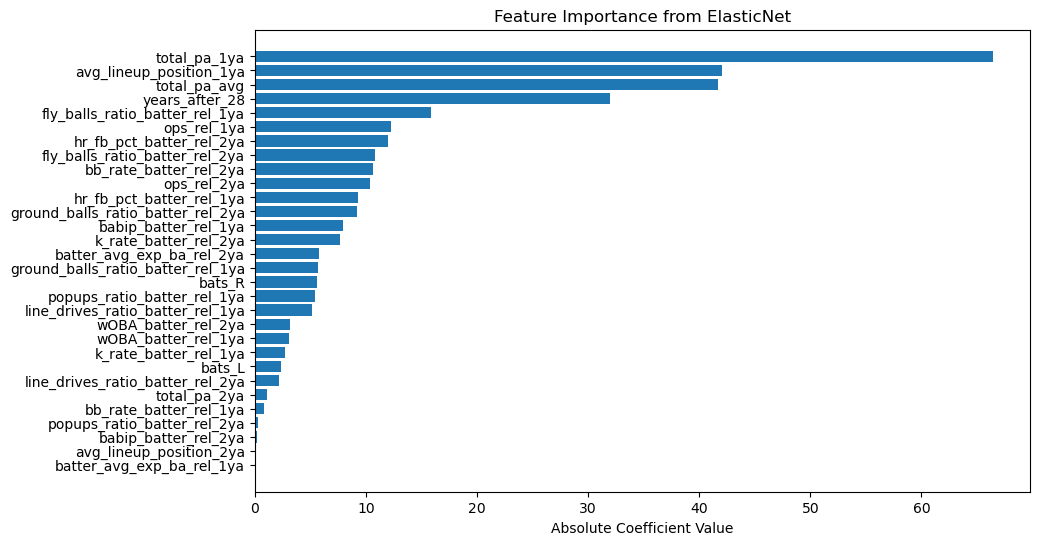

In [982]:
coefficients = elastic_net.coef_

# Create a DataFrame for the coefficients to associate with feature names
# After scaling, the feature names are lost, so we use the columns from X
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,  # Use the original feature names from X
    'Coefficient': coefficients
})

# Sort the features by the absolute value of the coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Print the feature importance
print(feature_importance)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance from ElasticNet')
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

In [984]:
print("\nActual vs Predicted Values:")
print(pd.DataFrame({"Actual": y_test, "Predicted": y_pred}).head(20))  # Show first 20 rows


Actual vs Predicted Values:
      Actual  Predicted
346      377      94.82
2122     420     187.51
2062     493     358.39
1471     686     595.61
2077       0      99.43
907       66      30.74
1412     599     481.65
1960     104      51.92
378      350     470.78
2290      61     180.03
37       469     420.50
1495     318     202.75
2227     349     319.57
1587     293     177.62
110      652     521.77
467       89     245.41
265      300     186.08
2176     369     425.93
130      672     462.57
1092      52     225.20


In [966]:
df_all.loc[467]['ops_rel_2ya']

98.68000980169269